In [1]:
from thetis import *
from firedrake_adjoint import *

In [2]:
import adolc
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as si
import scipy.optimize as so

In [3]:
from adapt_utils.case_studies.tohoku.options.okada_options import TohokuOkadaBasisOptions
from adapt_utils.norms import vecnorm
from adapt_utils.misc import ellipse

In [4]:
def plot_field(field, figure=None, axes=None, height=5, **kwargs):
    CG1 = field.ufl_element().degree() == 1 and field.ufl_element().family() == 'Lagrange'
    fs_constructor = FunctionSpace if len(field.function_space().shape) == 0 else VectorFunctionSpace
    out = field if CG1 else interpolate(field, fs_constructor(field.function_space().mesh(), "CG", 1))
    
    if figure is None and axes is None:
        figure, axes = plt.subplots(figsize=(height*1.2, height))
    if axes is None:
        axes = plt.gca()
    figure.colorbar(tricontourf(out, levels=50, axes=axes, cmap='coolwarm', **kwargs), ax=axes);
    axes.axis(False);
    axes.set_title(field.dat.name);
    return axes

# Forward model

Following the parameter redundancy experiment, we only allow variations in slip.

In [5]:
level = 0
op = TohokuOkadaBasisOptions(level=level, synthetic=False)
gauges = list(op.gauges.keys())
for gauge in gauges:
    if gauge[:2] not in ('P0','80'):
        op.gauges.pop(gauge)
gauges = list(op.gauges.keys())
print(gauges)
op.active_controls = ['slip', 'rake']
num_active_controls = len(op.active_controls)
op.end_time = 60*30

['801', '802', '803', '804', '806', '807', 'P02', 'P06']


In [6]:
mesh = op.default_mesh
P2_vec = VectorFunctionSpace(mesh, "CG", 2)
P1 = FunctionSpace(mesh, "CG", 1)
P0 = FunctionSpace(mesh, "DG", 0)
TaylorHood = P2_vec*P1

In [7]:
b = Function(P1).assign(op.set_bathymetry(P1))
g = Constant(op.g)
f = Function(P1).assign(op.set_coriolis(P1))

In [8]:
boundary_conditions = {100: ['freeslip', 'dirichlet'], 200: ['freeslip'], 300: ['freeslip']}

In [9]:
dtc = Constant(op.dt)

u, eta = TrialFunctions(TaylorHood)
z, zeta = TestFunctions(TaylorHood)
q_ = Function(TaylorHood)
u_, eta_ = q_.split()

a = inner(z, u)*dx + inner(zeta, eta)*dx
L = inner(z, u_)*dx + inner(zeta, eta_)*dx

n = FacetNormal(mesh)

def G(uv, elev):
    F = g*inner(z, grad(elev))*dx
    F += f*inner(z, as_vector((-uv[1], uv[0])))*dx
    F += -inner(grad(zeta), b*uv)*dx
    for tag in boundary_conditions:
        if "freeslip" not in boundary_conditions[tag]:
            F += inner(zeta*n, b*uv)*ds(tag)
    return F

a += 0.5*dtc*G(u, eta)
L += -0.5*dtc*G(u_, eta_)

q = Function(TaylorHood)
u, eta = q.split()

bcs = []
for tag in boundary_conditions:
    if "dirichlet" in boundary_conditions[tag]:
        bcs.append(DirichletBC(TaylorHood.sub(1), 0, tag))

params = {
    "snes_type": "ksponly",
    "ksp_type": "gmres",
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "multiplicative",
}

problem = LinearVariationalProblem(a, L, q, bcs=bcs)
solver = LinearVariationalSolver(problem, solver_parameters=params)

# Source model

Annotate the source model to ADOL-C's tape

ADOL-C: num_independents    : 380
ADOL-C: num_dependents      : 1800
ADOL-C: num_max_lives       : 524288
ADOL-C: tay_stack_size      : 0
ADOL-C: op_buffer_size      : 50000000
ADOL-C: num_operations      : 1374263
ADOL-C: op_file_access      : 0
ADOL-C: num_locations       : 3428584
ADOL-C: loc_file_access     : 0
ADOL-C: num_values          : 685140
ADOL-C: val_file_access     : 0
ADOL-C: loc_buffer_size     : 50000000
ADOL-C: val_buffer_size     : 50000000
ADOL-C: tay_buffer_size     : 50000000


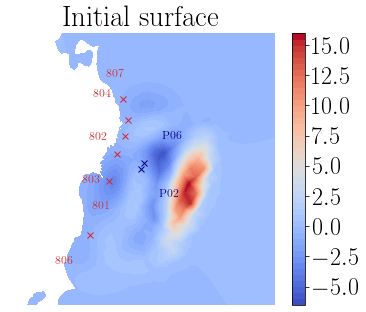

In [10]:
tape_tag = 0
q0 = Function(TaylorHood)
# eta0 = Function(P1)
with stop_annotating():
    q0.assign(0.0)
    u0, eta0 = q0.split()
    op.create_topography(annotate=True, tag=tape_tag, separate_faults=False)
    eta0.dat.data[op.indices] = op.fault.dtopo.dZ.reshape(op.fault.dtopo.X.shape)
eta0.dat.name = "Initial surface"

axes = plot_field(eta0);
xg, yg = op.gauges["P02"]["coords"]
axes.set_xlim([xg - 0.3e+06, xg + 0.3e+06]);
axes.set_ylim([yg - 0.35e+06, yg + 0.35e+06]);
op.annotate_plot(axes)

q_init = Function(TaylorHood)
q_init.project(q0)

stats = adolc.tapestats(tape_tag)
for key in stats:
    print("ADOL-C: {:20s}: {:d}".format(key.lower(), stats[key]))
num_subfaults = len(op.subfaults)

## Forward solve

Now run the forward model, time integrating the QoI as time progresses.

In [11]:
def solve_forward(init):
    q_.assign(init);
#     eta_.assign(init)
    t = 0.0
    J = 0
    wq = Constant(0.5)
    eta_obs = Constant(0.0)
    for gauge in op.gauges:
        op.gauges[gauge]['init'] = eta_.at(op.gauges[gauge]['coords'])
        eta_obs.assign(op.gauges[gauge]['init'])
        J = J + assemble(0.5*wq*dtc*op.gauges[gauge]['indicator']*(eta_ - eta_obs)**2*dx)
    while t < op.end_time:

        # Solve forward equation at current timestep
        solver.solve()
        q_.assign(q)
        t += op.dt

        # Time integrate QoI
        wq.assign(0.5 if t >= op.end_time - 0.5*op.dt else 1.0)
        for gauge in op.gauges:

            # Interpolate observations
            eta_obs.assign(float(op.gauges[gauge]['interpolator'](t)) + op.gauges[gauge]['init'])

            # Continuous form of error
            J = J + assemble(0.5*wq*dtc*op.gauges[gauge]['indicator']*(eta - eta_obs)**2*dx)

    assert np.allclose(t, op.end_time), "mismatching end time ({:.2f} vs {:.2f})".format(t, op.end_time)
    return J

Define gauge indicators

In [12]:
radius = 20.0e+03*pow(0.5, level)  # The finer the mesh, the more precise the indicator region
for gauge in gauges:
    loc = op.gauges[gauge]["coords"]
    op.gauges[gauge]['indicator'] = interpolate(ellipse([loc + (radius,)], mesh), P0)
    area = assemble(op.gauges[gauge]['indicator']*dx)
    op.gauges[gauge]['indicator'].assign(op.gauges[gauge]['indicator']/area)
    op.sample_timeseries(gauge, sample=op.gauges[gauge]['sample'], detide=True)

Run tsunami propagation, annotating pyadjoint's tape

In [13]:
c = Control(q_init)
# c = Control(eta0)

In [14]:
J = solve_forward(q_init)
# J = solve_forward(eta0)
print("Quantity of interest = {:.4e}".format(J))

Quantity of interest = 3.7722e+04


## Discrete adjoint

Note that we only Taylor test the elevation and effectively zero out the perturbation away from the source.

In [15]:
stop_annotating();

In [16]:
rf_pyadjoint = ReducedFunctional(J, c)

In [17]:
np.random.seed(0)
m0 = Function(TaylorHood).assign(q_init)
dm0 = Function(TaylorHood)
dm0.dat.data[1][:] = np.random.rand(*dm0.dat.data[1].shape)*m0.dat.data[1]
# m0 = Function(eta0)
# dm0 = Function(eta0)
# dm0.dat.data[:] = np.random.rand(*dm0.dat.data.shape)
minconv = taylor_test(rf_pyadjoint, m0, dm0)
assert minconv > 1.90, minconv

Running Taylor test
epsilon 1.0000e-02  residual 1.1020e+00
epsilon 5.0000e-03  residual 2.5644e-01
epsilon 2.5000e-03  residual 3.5128e-02
epsilon 1.2500e-03  residual 3.9170e-02
Computed residuals: [1.1019823788606686, 0.2564421925460749, 0.035128138481368865, 0.03916966351498985]
Computed convergence rates: [2.1033956009779056, 2.8679346166704427, -0.15710960799451398]


AssertionError: -0.15710960799451398

In [18]:
def rf_pyadolc(m):
    q0_tmp = Function(TaylorHood)
    q0_tmp.assign(0.0)
    u0_tmp, eta0_tmp = q0_tmp.split()
    eta0_tmp.dat.data[op.indices] = adolc.zos_forward(tape_tag, m, keep=1)
    return q0_tmp

In [19]:
def reduced_functional(m):
    """
    Compose both unrolled tapes
    """
#     op._J = rf_pyadjoint(rf_pyadolc(m))
    op._J = solve_forward(rf_pyadolc(m))
    return op._J

In [20]:
def gradient(m):
    """
    Apply the chain rule to both tapes
    """
    J = rf_pyadjoint(rf_pyadolc(m))
#     J = solve_forward(rf_pyadolc(m))
    dJdq0 = rf_pyadjoint.derivative()
    dJdu0, dJdeta0 = dJdq0.split()
    dJdeta0 = dJdeta0.dat.data[op.indices]
    dJdm = adolc.fos_reverse(tape_tag, dJdeta0)
    print("functional {:.8e}  gradient {:.8e}".format(op._J, vecnorm(dJdm, order=np.Inf)))
    return dJdm

In [21]:
c = np.concatenate([op.control_parameters[ctrl] for ctrl in op.active_controls])

In [22]:
def callback(m):
    print("Line search complete")

In [23]:
# Run optimisation
print_output("Optimisation begin...")
opt_kwargs = {
    'maxiter': 1000,
    'gtol': 1.0e-08,
    'fprime': gradient,
    'callback': callback,
}
optimised_value = so.fmin_bfgs(reduced_functional, c, **opt_kwargs)

Optimisation begin...


functional 1.27711831e+06  gradient 6.07138395e+02
functional 1.26814558e+06  gradient 6.06273955e+02
functional 1.23266728e+06  gradient 6.02437447e+02
functional 1.09739539e+06  gradient 5.81368493e+02
functional 6.63200144e+05  gradient 4.27295737e+02
Line search complete
functional 1.97328602e+06  gradient 2.28074026e+03


KeyboardInterrupt: 

In [ ]:
q0_opt = rf_pyadolc(optimised_value)

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(19, 8))
u0_opt, eta0_opt = q0_opt.split()
tc = tricontourf(eta0_opt, axes=axes[i], cmap='coolwarm', levels=50)
cbar = fig.colorbar(tc, ax=axes[i])
axes[i].axis(False);

# TODO:
* Plot optimisation progress
* Plot timeseries